1. Import Libraries

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import numpy as np


2. Settings 

Set hyperparameters for binary classification. The model will classify images into two categories: benign and malignant. Pruning 30% of the model weights.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

num_classes = 3
batch_size = 16
epochs = 5
prune_amount = 0.3
data_dir = "data"  # should contain 'train' and 'val'

Using device: cuda
Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


3. Data Loaders :
resized to 256×256 and loads your data into batches ready for training

In [3]:
transform = transforms.Compose([
    transforms.Resize((380, 380)), # Resize the image to 256x256 
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    transforms.RandomRotation(10), # Randomly rotate the image by 10 degrees
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(f"{data_dir}/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


4. Model Selection Function : chosen model (ResNet50, DenseNet121, or EfficientNetB0) with the output layer modified for 3 classes.

In [4]:
# === Models ===
def get_model(model_name):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "densenet121":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == "efficientnet_b4":
        model = models.efficientnet_b4(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError(f"Model {model_name} not supported.")

    return model.to(device)


 5. Pruning Function : Prunes (zeroes out) 30% of the smallest weights in each convolutional and linear layer. This makes models lighter and faster, but may reduce accuracy.



In [5]:
# === Pruning Function ===
def apply_pruning(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
    return model


 6. Training and Evaluation

In [6]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

#  evaluates accuracy each epoch. output Training loss,Validation accuracy
def train_model(model, name, train_loader, val_loader, criterion, optimizer, epochs=5):
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        val_acc = evaluate(model, val_loader)
        train_losses.append(avg_loss)
        val_accuracies.append(val_acc)

        print(f"{name} | Epoch {epoch+1}/{epochs}: Loss={avg_loss:.4f}, Val Acc={val_acc:.4f}")

    return {'name': name, 'loss': train_losses, 'val_acc': val_accuracies}

7. Train and Compare Models

In [7]:
models_to_run = ["resnet50", "densenet121", "efficientnet_b4", "mobilenet_v2"]

results = []
criterion = nn.CrossEntropyLoss()

# === Main Training Loop ===
for model_name in models_to_run:
    print(f"\nTraining {model_name.upper()}...")
    model = get_model(model_name)
    model = apply_pruning(model, amount=prune_amount)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    result = train_model(model, model_name, train_loader, val_loader, criterion, optimizer, epochs)
    results.append(result)


Training RESNET50...


d:\LernNewCode\Trymodel\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\LernNewCode\Trymodel\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resnet50 | Epoch 1/5: Loss=0.9922, Val Acc=0.4444
resnet50 | Epoch 2/5: Loss=0.6423, Val Acc=0.5000
resnet50 | Epoch 3/5: Loss=0.3119, Val Acc=0.7222
resnet50 | Epoch 4/5: Loss=0.1945, Val Acc=0.6667
resnet50 | Epoch 5/5: Loss=0.1419, Val Acc=0.6111

Training DENSENET121...


d:\LernNewCode\Trymodel\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


densenet121 | Epoch 1/5: Loss=1.0039, Val Acc=0.3333
densenet121 | Epoch 2/5: Loss=0.7507, Val Acc=0.5000
densenet121 | Epoch 3/5: Loss=0.5679, Val Acc=0.4444
densenet121 | Epoch 4/5: Loss=0.3623, Val Acc=0.5556
densenet121 | Epoch 5/5: Loss=0.2423, Val Acc=0.6111

Training EFFICIENTNET_B4...


d:\LernNewCode\Trymodel\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


efficientnet_b4 | Epoch 1/5: Loss=1.0925, Val Acc=0.3889
efficientnet_b4 | Epoch 2/5: Loss=1.0882, Val Acc=0.3333
efficientnet_b4 | Epoch 3/5: Loss=1.0780, Val Acc=0.5000
efficientnet_b4 | Epoch 4/5: Loss=1.0702, Val Acc=0.2222
efficientnet_b4 | Epoch 5/5: Loss=1.0625, Val Acc=0.5000

Training MOBILENET_V2...


d:\LernNewCode\Trymodel\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


mobilenet_v2 | Epoch 1/5: Loss=1.0495, Val Acc=0.3889
mobilenet_v2 | Epoch 2/5: Loss=0.8223, Val Acc=0.3333
mobilenet_v2 | Epoch 3/5: Loss=0.7102, Val Acc=0.5000
mobilenet_v2 | Epoch 4/5: Loss=0.5501, Val Acc=0.6111
mobilenet_v2 | Epoch 5/5: Loss=0.4476, Val Acc=0.5556


 8. Visualization of Model Comparison

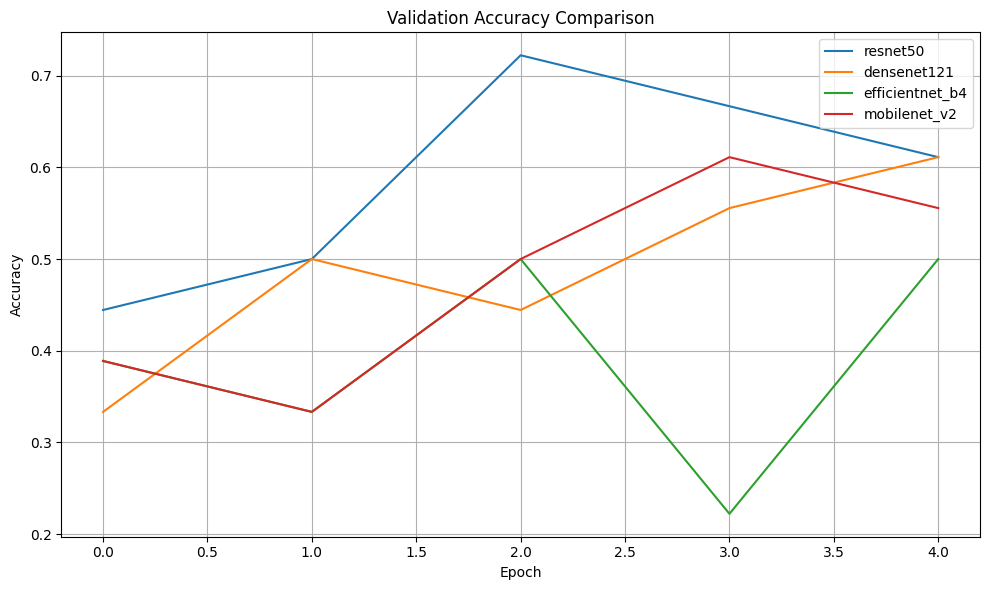

In [8]:
# Plotting validation accuracy for all models
plt.figure(figsize=(10, 6))

for res in results:
    plt.plot(res['val_acc'], label=res['name'])

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

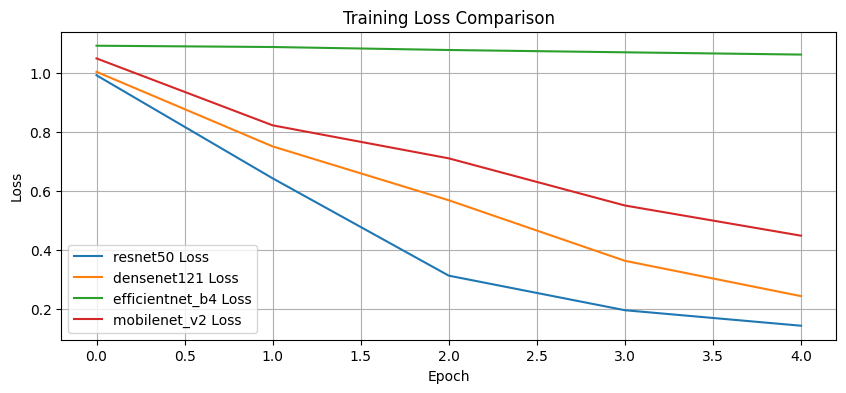

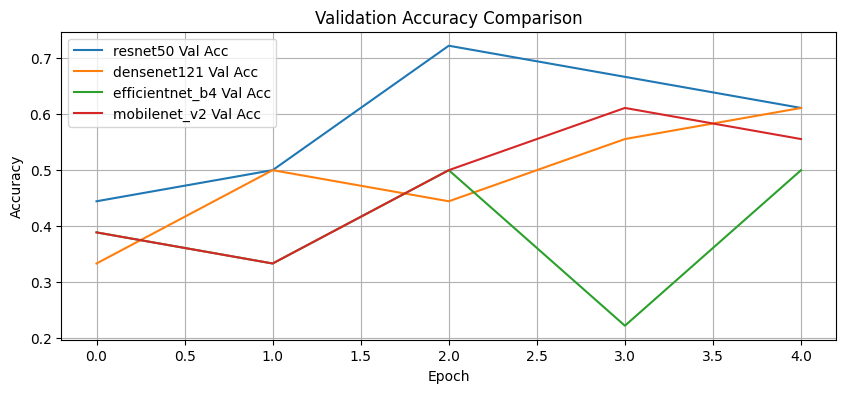

In [9]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 4))
for res in results:
    plt.plot(res['loss'], label=f"{res['name']} Loss")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 4))
for res in results:
    plt.plot(res['val_acc'], label=f"{res['name']} Val Acc")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
